# Data Cleaning

In this notebook, we will clean the data and prepare it for the NLP models.

# Import Libraries

In [37]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# NLP Packages
import nltk 
from nltk.corpus import stopwords
from textblob import TextBlob 
from textblob import Word
import re
import string

# Sklearn Packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

# Pandas Settings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

import pickle

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import Dataset

In [45]:
# Import csv file
df = pd.read_csv('../csv/Hotel_Reviews.csv')

In [46]:
# Checking the shape of the dataframe
df.shape

(515738, 17)

# Data Preparation

Here we can see that the dataset is large. Some models could take way too long to run a train set this size. Thus, in the first part of this project, I will use 20% of the original dataset. Further in the project, I'm planning on testing best model on the entire dataset. Luckily, since the dataset is so large, we can fix any class imbalance here.

## Keep only columns I will use to train my models

In [47]:
# Checking the name of columns
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [48]:
# Selecting only the columns that I will use
features = ['Hotel_Name', 'Negative_Review','Positive_Review', 'Reviewer_Score']
df = df[features]

For NLP, I want to see how the model performs having the positive reviews together, since that's the way that most people write reviews.

In [49]:
# Putting reviews together
df['Reviews'] = df['Negative_Review'] + df['Positive_Review']

In [51]:
# Keep only 20% of the dataframe
df = df.sample(frac=0.20, random_state=1)

In [52]:
# Checking if it worked
df.shape

(103148, 5)

In [53]:
# Checking null values
df.isna().sum()

Hotel_Name         0
Negative_Review    0
Positive_Review    0
Reviewer_Score     0
Reviews            0
dtype: int64

In [54]:
# Checking how many hotels in this dataset
len(df.Hotel_Name.unique())

1488

In [55]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           965
Strand Palace Hotel                                  900
Park Plaza Westminster Bridge London                 846
Copthorne Tara Hotel London Kensington               748
DoubleTree by Hilton Hotel London Tower of London    641
dtype: int64

We now have only 20% of the dataset. We can see that Britannia International Hotel Canary Wharf is still the hotel with the most reviews, which shows us that pandas sample function really works as expected. I mentioned this in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook.

# Data Cleaning

Now it's time to clean data. The function below lowercase all the words, removes punctuations, and digits.

In the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook I explain that the lowest score is 2.5, which I believe the users don't have the option to choose the score and it must be automatic. For this reason, there are only scores between 2.5 and 10. For this reason, I choose the half point between these two numbers to create my variable.

In [56]:
# This function lowercase all the review words, removes punctuation and numbers
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

round1 = lambda x: clean_text_round1(x)

In [57]:
# Applying clean_text_round1 function
df['Reviews_Clean'] = pd.DataFrame(df.Reviews.apply(round1))

Create a binary classification where anything below 6 is negative review and 6 and above is positive.

In [58]:
# Create function that turns the Reviewer Score into a classification target with 3 values
df['Score'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 6 else 1)

In [59]:
# Checking if it worked
df[['Reviewer_Score', 'Score']].head(5)

,Reviewer_Score,Score
356054,10.0,1
395957,10.0,1
468352,6.7,1
281462,9.6,1
498978,10.0,1


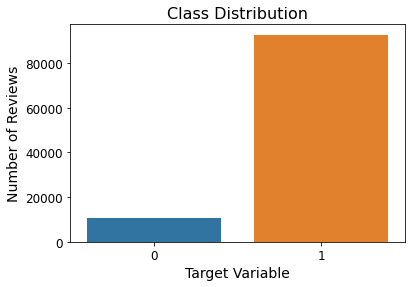

In [71]:
# Checking if the target variable is balanced
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('../images/class_distribution-before.png', bbox_inches = "tight", pad_inches=.5)

In [72]:
# Checking if there will be class imbalance
df.Score.value_counts()

1    92645
0    10503
Name: Score, dtype: int64

We can see that there is a big class imbalance. Since our dataset is large, we can fix this using the pandas sample function. Thus, I will only use 12% of the positive reviews, so it will get closer to the number of negative reviews.

In [73]:
# Creating separate dataframes depending on the classification
df_Score_0 = df[df.Score == 0]
df_Score_1 = df[df.Score == 1].sample(frac=0.12)

In [74]:
# Concatenating th 
df = pd.concat([df_Score_1, df_Score_0])
df.shape

(21620, 7)

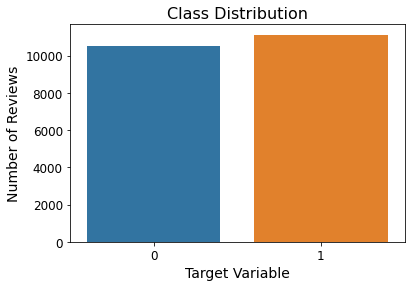

In [75]:
# Checking if the target variable is balanced
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('../images/class_distribution-after.png', bbox_inches = "tight", pad_inches=.5)

In [21]:
df.Score.value_counts()

1    11117
0    10503
Name: Score, dtype: int64

Checking if the class imbalance worked.

In [22]:
# Saving csv with sentiment analysis
features = ['Hotel_Name', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Reviews_Clean', 'Score']
df = df[features]
df.to_csv("../csv/no_class_imbalance.csv")

# Spell Checker

Let's fix any spelling mistakes in the review using TextBlob.

## Tokenizer - Round 1

In [23]:
# Setting stop words
stop_words = stopwords.words('english')

In [24]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Reviews_Clean'])
df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
df_cv.index = df.index
df_cv.shape

(21620, 17836)

<b>IMPORTANT NOTE:</b>

The cell below exports the dataset with the spelling checked. If you export it without running the Spell Checker, all the models won't have the target correctly set up. Thus, I don't recommend exporting that cell.

In [38]:
# # Checking if function works
# df['Spell_Checked'] = df['Reviews_Clean'].apply(lambda x: ''.join(TextBlob(x).correct()))

# 1h 21m to run

In [39]:
# # Fit and transform dataframe without data cleaning
# df_cv = cv.fit_transform(df['Spell_Checked'])
# df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
# df_cv.index = df.index
# df_cv.shape

(21619, 11930)

Done! We reduced our dataset from 17,836 words to 11,930 words. WOW!

In [40]:
# df.to_csv('../csv/Hotel_Review_Spell_Checked.csv')

## Tokenizing and Processing Data

Let's now preprocess the cleaned dataset before modeling. I will also lemmatize the words. I want to try models with both lemmatized and non-lemmatized words.

In [76]:
# Importing the dataset with the spelling checked
df = pd.read_csv('../csv/Hotel_Review_Spell_Checked.csv', index_col=0)

In [77]:
# Dropping null values, if any
df.dropna(inplace=True)

Let's now create a new dataset with only the information that I will use for modeling: the spell checked variable as my features and the score as my target.

In [78]:
# Create a new dataset with only the information that I will use for modeling
cleaned_review = df[['Spell_Checked', 'Score']]

In [44]:
# Setting the training and target variables
data = cleaned_review['Spell_Checked']
target = cleaned_review['Score']

In [45]:
# Tokenizing model and run one more round of stop words cleaning
def process_review(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [46]:
# Applying process_review to the data
processed_data = list(map(process_review, data))

In [47]:
# Counting how many words there are
total_vocab = set()
for review in processed_data:
    total_vocab.update(review)
len(total_vocab)

11947

Cool, now the dataset is ready for some modeling, but before I move on, I will also lemmatize the words, so I can try the lemmatized and non-lemmatized datasets and see which on works the best.

## Lemmatization

In [51]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [52]:
X_lem = lemmatized_output
y_lem = target

X and y variables are ready for use. Let's pickle them.

## Pickle

In [54]:
# pickle these for modeling
pickle_out = open('../pickle/X_lem.pkl','wb')
pickle.dump(X_lem, pickle_out)
pickle_out.close()

In [55]:
y_lem.to_pickle('../pickle/y_lem.pkl')